In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import glob
import os

import tqdm
import optuna
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = dd.read_csv("Files/Train/train_1.csv")
train_df.head()

,target,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,feature_500
0,0,train,0,0.372342,1.500852,2.133451,-0.957384,-0.119022,0.122920,0.150993,...,-1.254497,0.0,0.803635,-1.017931,-0.521130,0.647188,1.453860,-0.833480,0.184028,-0.438225
1,0,train,1,0.382215,0.962629,-0.192558,-1.019986,-1.330412,-0.100149,-1.131326,...,-0.884458,0.0,-1.643735,-1.264842,-1.523788,0.604948,0.491954,-0.003686,0.469720,-1.094604
2,0,train,2,0.472528,-0.695334,0.537968,-0.033000,-0.364850,-0.441849,-0.035953,...,-0.322682,0.0,-0.496765,-0.051931,0.743209,-1.395109,0.147941,-0.007553,-0.981296,0.270930
3,0,train,3,0.512260,-1.231960,0.555326,1.456647,1.435358,0.168613,-0.628737,...,0.976566,0.0,1.183049,-0.178662,1.468147,-0.791254,0.000645,0.674715,0.803094,1.037068
4,0,train,4,1.487986,-0.164392,-1.197163,1.549057,0.952673,1.144201,-0.964000,...,-1.655236,0.0,1.076122,-0.555735,1.248728,-0.485943,0.458768,-0.444558,-0.333710,0.380206


In [3]:
csv_files = glob.glob(os.path.join('train_df_target_1', "*.csv"))

df_list = []

for f in csv_files:
    df = pd.read_csv(f, index_col=None)
    df_list.append(df)

df_target_1 = pd.concat(df_list, ignore_index=True)
df_target_1.head()

,Unnamed: 0,target,smpl,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,feature_500
0,3,1,train,186904,1.159081,0.137804,-1.146452,-0.043139,-0.034221,-1.348065,...,0.185804,0.0,-0.429581,0.272467,-1.659469,0.181085,-0.464260,-0.679452,1.189937,-1.816185
1,4,1,train,224283,-0.864559,0.406952,-0.731589,0.404795,0.595640,-2.424691,...,-0.708631,0.0,1.294737,0.516589,-0.228073,0.648548,0.286376,-3.145413,-0.862285,3.292564
2,5,1,train,349158,0.041674,0.678160,-1.886594,-0.597819,-0.055541,-2.369538,...,0.057093,0.0,-0.374733,1.683908,0.028179,-0.553447,-1.444411,0.826495,-1.440725,1.446247
3,6,1,train,24928,0.495197,1.832900,0.744773,-0.555244,1.703822,1.262357,...,-0.971954,0.0,-0.076028,0.730970,-1.193405,-1.050291,-0.164680,1.010393,0.812648,-0.556589
4,7,1,train,161989,-1.278955,-0.959388,0.517184,-1.022227,0.150069,0.517707,...,-0.871591,0.0,0.697450,0.251525,-0.762436,0.376194,-1.039916,-0.109402,0.012253,0.037284


In [5]:
df_target_1_new = df_target_1.drop(columns=['smpl', 'Unnamed: 0', 'id'])
df_target_0 = train_df[train_df['target'] == 0].compute().iloc[:len(df_target_1_new),:]
df_target_0_new = df_target_0.drop(columns=['smpl', 'id'])

In [8]:
full_train_df = pd.concat([df_target_0_new, df_target_1_new])
full_train_df.head()

,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,feature_500
0,0,0.372342,1.500852,2.133451,-0.957384,-0.119022,0.122920,0.150993,0.506717,-0.839165,...,-1.254497,0.0,0.803635,-1.017931,-0.521130,0.647188,1.453860,-0.833480,0.184028,-0.438225
1,0,0.382215,0.962629,-0.192558,-1.019986,-1.330412,-0.100149,-1.131326,-1.173272,-1.790011,...,-0.884458,0.0,-1.643735,-1.264842,-1.523788,0.604948,0.491954,-0.003686,0.469720,-1.094604
2,0,0.472528,-0.695334,0.537968,-0.033000,-0.364850,-0.441849,-0.035953,-0.921158,0.746746,...,-0.322682,0.0,-0.496765,-0.051931,0.743209,-1.395109,0.147941,-0.007553,-0.981296,0.270930
3,0,0.512260,-1.231960,0.555326,1.456647,1.435358,0.168613,-0.628737,0.249797,1.475977,...,0.976566,0.0,1.183049,-0.178662,1.468147,-0.791254,0.000645,0.674715,0.803094,1.037068
4,0,1.487986,-0.164392,-1.197163,1.549057,0.952673,1.144201,-0.964000,0.031899,1.262253,...,-1.655236,0.0,1.076122,-0.555735,1.248728,-0.485943,0.458768,-0.444558,-0.333710,0.380206


In [10]:
full_train_df.shape

(309658, 501)

In [41]:
# rows, cols = train_df_target_1.shape
# shape = (rows.compute(), cols)
# print(f"Shape of the Dask DataFrame: {shape}")

Shape of the Dask DataFrame: (154829, 503)


In [11]:
categorial_features = ['feature_17', 'feature_21', 'feature_22', 'feature_27', 'feature_31', 'feature_43', 'feature_61', 'feature_64', 'feature_80', 'feature_83', 'feature_92', 'feature_133', 'feature_143', 'feature_166', 'feature_173', 'feature_191', 'feature_201', 'feature_209', 'feature_251', 'feature_253', 'feature_299', 'feature_300', 'feature_343', 'feature_347', 'feature_382', 'feature_392', 'feature_405', 'feature_406', 'feature_423', 'feature_434', 'feature_446', 'feature_449', 'feature_459', 'feature_490', 'feature_492']

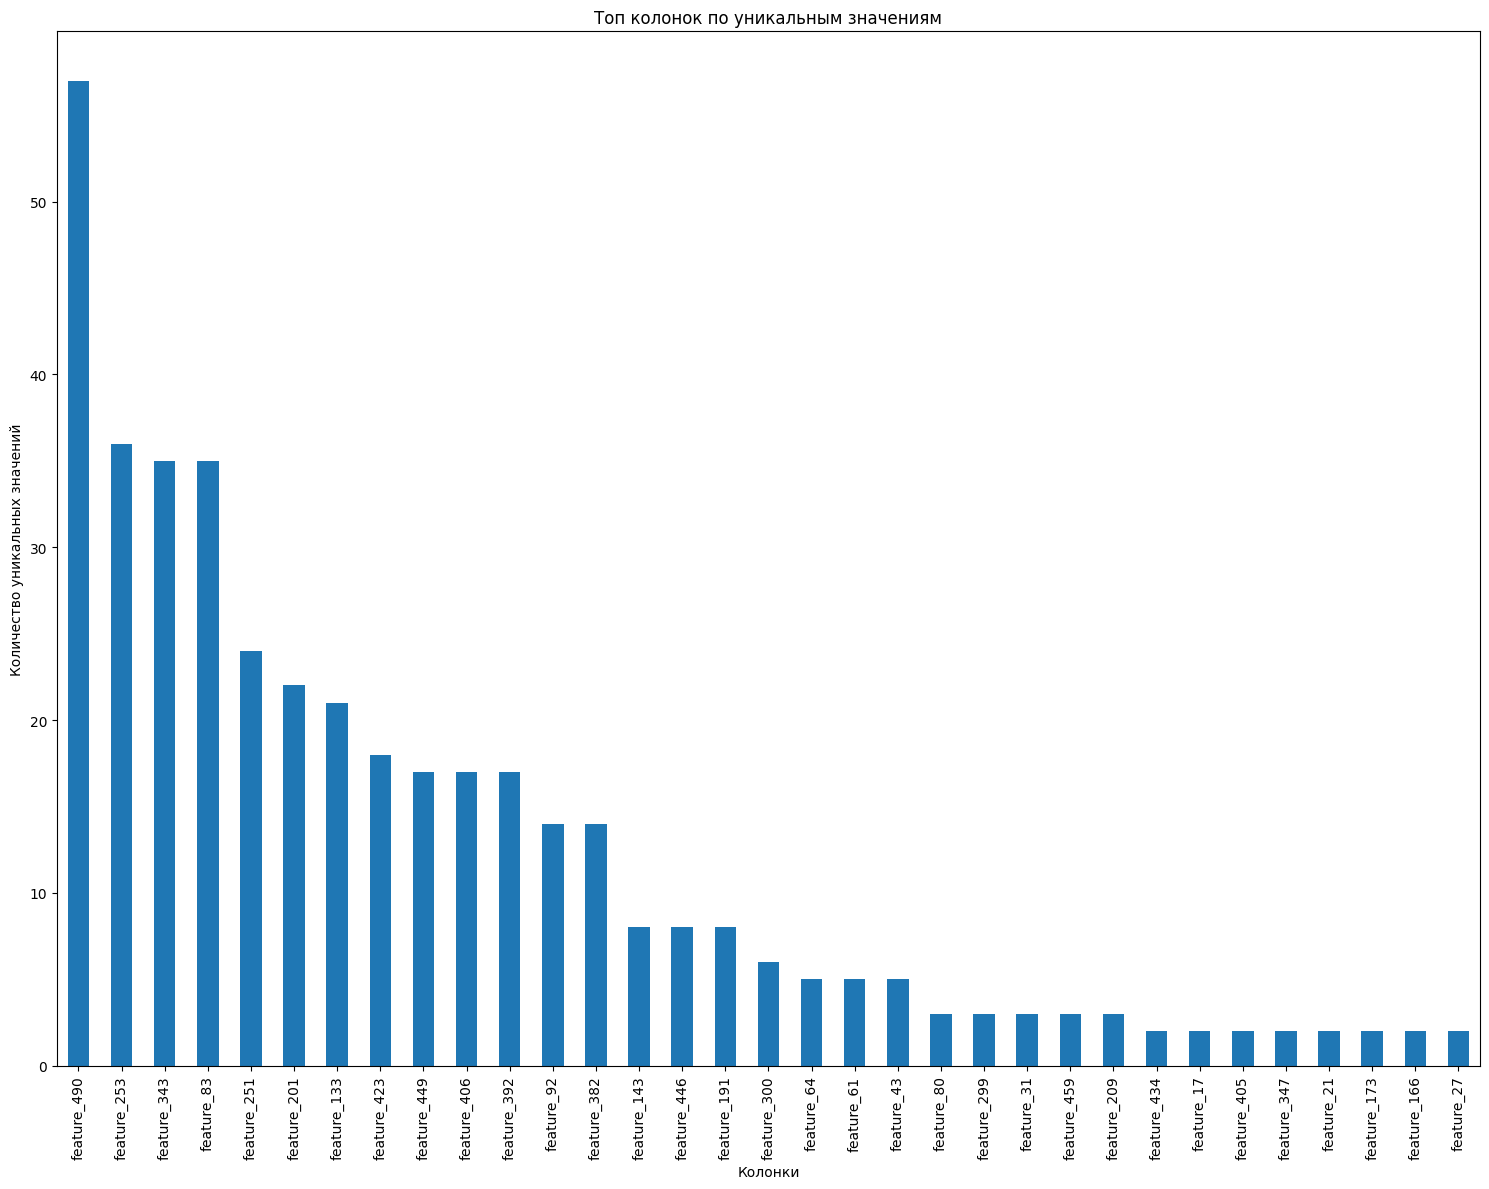

In [22]:
unique_counts = full_train_df[categorial_features].nunique().sort_values(ascending=False)
top_cols = unique_counts.head(len(categorial_features) - 2)

plt.figure(figsize=(15, 12))
top_cols.plot(kind='bar')
plt.ylabel('Количество уникальных значений')
plt.xlabel('Колонки')
plt.title('Топ колонок по уникальным значениям')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

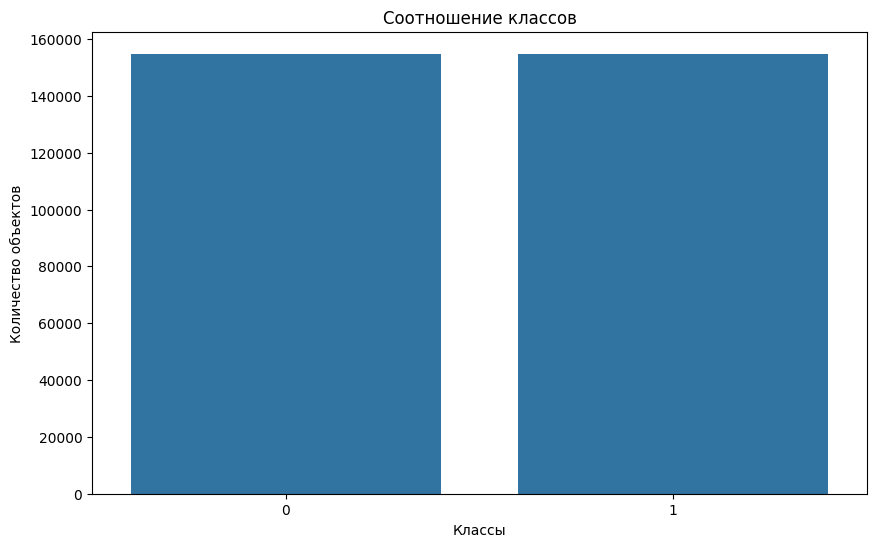

In [23]:
class_counts = full_train_df['target'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=full_train_df)
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.title('Соотношение классов')
plt.show()

In [24]:
class_counts

target
0    154829
1    154829
Name: count, dtype: int64